# DivExplorer analysis - Example with COMPAS dataset 

In [2]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import dataset

In this running example we analyze the [COMPAS](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) dataset.

We import an already pre-processed and discretized version. You can refer to this [notebook](www.google.com) for its pre-processing.

The COMPAS dataset contains demographic information and the criminal history of defendants.
For each criminal defendant, the following attributes are available:
- *age_cat*: age category of the defendant. 
- *c_charge_degree*: severity of the charge. 'M'='Misdemeanor','F'='Felony' 
- *race*: 'Afr-Am', 'Asian', 'Cauc', 'Hispanic', 'Native American', 'Other'
- *sex*: 'Female', 'Male'
- *length_of_stay*: the days spent in jail, derived from the records of the date in which the person entered lastly the jail and the date in which the person was released.
- *priors_count*: the number of prior crimes committed.


For each defendant, the dataset also records:
- the *class*, whether the defendant recidivated (was arrested again) in the next two years. It is 1 if the defendant recidivated, 0 otherwise.
- the *predicted* recidivism, derived from the COMPAS score of recidivism risk assesses the defendant’s likelihood of committing another offense in a period of two years. It is 1 if the risk is high.

In [5]:
import pandas as pd

df = pd.read_csv("datasets/compas_discretized.csv")
df.head()

,age,charge,race,sex,#prior,stay,class,predicted
0,>45,F,Other,Male,0,<week,0,0
1,25-45,F,Afr-Am,Male,0,1w-3M,1,0
2,<25,F,Afr-Am,Male,>3,<week,1,0
3,25-45,M,Other,Male,0,<week,0,0
4,25-45,F,Cauc,Male,>3,<week,1,0


## Divergence of Boolean Outcomes

DivExplorer enables to identify data subgroups that behave in a way that is different from the rest of the dataset.
To use DivExplorer, one first defines a statistical property of interest, and then asks to find the subgroups that are "divergent", that is, behave differently, with respect to that property. 

The simplest properties are _boolean outcomes_. 
These are properties that can value 0, 1, or NaN for any data instance (that is, for any row).
0 indicates false, 1 indicates true, and NaN indicates that the instance (that is, the row) should not take part in the statistics. 

For a boolean outcome $\alpha$, DivExplorer then computes for any subgroup $S$ (a subgroup is a set of rows) the following quantity

$$
    f_\alpha(S) = \frac{|\alpha = 1|}{|\alpha \neq NaN|} , 
$$

that is, the rate of true vs. the total rate excluding NaNs. 
For every subgroup $S$, it computes the _divergence_ of $\alpha$ as 

$$
\Delta_\alpha(S) = f_\alpha(S) - f_\alpha(D) , 
$$

where $D$ is the entire dataset. 
That is, the divergence of $S$ is simply the difference in the average of $\alpha$ on $S$, and on the entire datset. 


### Divergence of Positive Rate

For instance, we can ask the subgroups that have more positives in the `class` column.  
Those will be the subgroups with more people, in percentage, that do recidivate. 

We first create a divergence explorer on the dataset. 

In [6]:
from divexplorer.divexplorer import DivergenceExplorer

fp_diver = DivergenceExplorer(df)


The following code identifies all subgrups that contain over 10% (or a fraction of 0.1) of the dataset, and will sort them according to their divergence of the `class` column, in ascending order -- so we list first the groups that have _least_ true recidivation rate. 

In [7]:
# These are the columns we want to use for subgroup formation.
attributes = ["age", "charge", "race", "sex", "#prior", "stay"]

FP_fm = fp_diver.get_pattern_divergence(min_support=0.1, attributes=attributes, 
                                        boolean_outcomes=['class'])
FP_fm.sort_values(by="class_div", ascending=True).head(10)

,support,itemset,class,class_div,class_t,length,support_count
90,0.146630,"(#prior=0, charge=M, stay=<week)",0.229834,-0.225286,14.643795,3,905.0
88,0.148250,"(#prior=0, stay=<week, age=25-45)",0.234973,-0.220147,14.284280,3,915.0
129,0.118600,"(#prior=0, race=Cauc, stay=<week)",0.236339,-0.218781,12.890008,3,732.0
83,0.155541,"(#prior=0, charge=M)",0.243750,-0.211370,13.847226,2,960.0
142,0.107097,"(#prior=0, stay=<week, sex=Male, age=25-45)",0.248109,-0.207011,11.500351,4,661.0
73,0.166235,"(#prior=0, age=25-45)",0.253411,-0.201709,13.438595,2,1026.0
152,0.101102,"(#prior=0, sex=Male, charge=M, stay=<week)",0.254808,-0.200312,10.764736,4,624.0
106,0.133020,"(#prior=0, race=Cauc)",0.257004,-0.198116,11.972214,2,821.0
76,0.158782,"(age=>45, stay=<week)",0.265306,-0.189814,12.256324,2,980.0
23,0.303143,"(#prior=0, stay=<week)",0.267771,-0.187349,15.547243,2,1871.0


We see that the people least likely to recidivate are those charged with misdemeanors, with no prior offences, and that stayed in prison for less than a week.  This makes sense.  For people in that subgroup, the recidivation rate is -0.23 the average one, and the difference is extremely statistically significative with a t-value of 14.64. 

#### False positive and negative rates

We can also study the divergence of false positive and negative rates.  This enables us to discover the subgroups on which classification makes most mistakes.  

To this end, we first add to the dataframe a new column, called `fp` (for, false-positive).
We define the value of `fp` as: 

* 1, if the data is a false positive (`class` is 0 and `predicted` is 1)
* 0, if the data is a true negative (`class` is 0 and `predicted` is 0). 
* NaN, if the data is a true positive.  True positives do not enter in the computation of false-positive rates. 

We use the `get_false_positive_rate_outcome` function to compute such column.  
See [our KDD paper](https://divexplorer.github.io/static/KDD_2021_DivExplorer.pdf) for more details. 

In [8]:
from divexplorer.outcomes import get_false_positive_rate_outcome

y_trues = df["class"].values
y_preds = df["predicted"].values

df['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds, negative_value=0)

# Shuffes the dataframe
dfs = df.sample(frac=1, random_state=11)
dfs.head(10)

,age,charge,race,sex,#prior,stay,class,predicted,fp
687,<25,F,Afr-Am,Male,"[1,3]",<week,1,0,NaN
3894,25-45,F,Afr-Am,Female,>3,<week,1,0,NaN
2200,25-45,M,Afr-Am,Male,>3,<week,1,1,NaN
5340,25-45,M,Cauc,Female,0,<week,0,0,0.0
857,25-45,F,Afr-Am,Male,0,<week,0,1,1.0
4859,25-45,F,Afr-Am,Male,"[1,3]",<week,0,0,0.0
5817,<25,M,Cauc,Male,"[1,3]",1w-3M,0,0,0.0
3058,25-45,M,Afr-Am,Male,0,<week,0,0,0.0
4010,25-45,M,Afr-Am,Male,>3,<week,1,0,NaN
1882,<25,F,Afr-Am,Male,0,<week,0,0,0.0


Once this new column is added, we can again ask for divergence.
The function `get_pattern_divergence` gets a list of boolean outcome columns, btw, because if you are interested in the divergence of several columns, it's far more efficient to do the computation all at once. 

In [9]:
fp_diver = DivergenceExplorer(df)

FP_fm = fp_diver.get_pattern_divergence(min_support=0.1, attributes=attributes, 
                                        boolean_outcomes=['fp'])
FP_fm.sort_values(by="fp_div", ascending=False).head(10)

,support,itemset,fp,fp_div,fp_t,length,support_count
113,0.128645,"(#prior=>3, sex=Male, race=Afr-Am, age=25-45)",0.308036,0.219722,7.116857,4,794.0
92,0.145010,"(#prior=>3, race=Afr-Am, age=25-45)",0.299242,0.210928,7.448260,3,895.0
135,0.109527,"(race=Afr-Am, charge=F, #prior=>3, age=25-45)",0.290155,0.201841,6.201585,4,676.0
109,0.130752,"(race=Afr-Am, sex=Male, charge=F, #prior=>3)",0.268722,0.180408,6.132988,4,807.0
67,0.175308,"(#prior=>3, sex=Male, race=Afr-Am)",0.266871,0.178557,7.214382,3,1082.0
55,0.196695,"(#prior=>3, race=Afr-Am)",0.261097,0.172783,7.582039,2,1214.0
87,0.148412,"(race=Afr-Am, charge=F, #prior=>3)",0.259124,0.170810,6.421341,3,916.0
105,0.133668,"(#prior=>3, sex=Male, charge=F, age=25-45)",0.258333,0.170019,6.011738,4,825.0
82,0.155865,"(#prior=>3, charge=F, age=25-45)",0.256055,0.167741,6.491614,3,962.0
63,0.180655,"(sex=Male, #prior=>3, age=25-45)",0.252941,0.164627,6.903692,3,1115.0


The output is a pandas DataFrame. Each row represent a frequent pattern with the following information:

- `support` is the frequency of the pattern in the dataset, that is, the fraction of dataframe rows that satisty the pattern. 
- `itemset` is the pattern - frozenset of items (str). This is the property that defines the subgroup. 
- `fp` is the false positive rate of the pattern
- `fp_div` is the divergence of the fpr = fpr(pattern) - fpr(all dataset)
- `fp_t` is the t-value of the fpr divergence, indicating statistical significance
- `lenght` is the number of items in the pattern
- `support_count` is the number of instances that satisfy the pattern

As we see, the false-positive rate is highest for Male African-Americans with at least 3 offenses, and with ages between 25 and 45. 

### DivergencePatternProcessor - Analysis of the divergence patterns

We can then drill into each pattern (or subgroup), to understand better what are the causes of its divergence.

In [10]:
from divexplorer.pattern_processor import DivergencePatternProcessor

# We create a pattern processor 
# We provide the dataframe and the name of the column that contains the outcome we want to analyze (fpr_outcome in this case)
fp_diver = DivergencePatternProcessor(FP_fm, 'fp')

#### Shapley Value

The divergence of each pattern can be attributed to the items (_attribute=value_ pairs) that compose it via the Shapley value. 

In [11]:
# Given a pattern, we can get the shapley value of the pattern
pattern = fp_diver.patterns['itemset'].iloc[113]
print(pattern)

sv = fp_diver.shapley_value(pattern)
sv

frozenset({'#prior=>3', 'sex=Male', 'race=Afr-Am', 'age=25-45'})


{frozenset({'#prior=>3'}): 0.14226087371897317,
 frozenset({'sex=Male'}): 0.007220590601649036,
 frozenset({'race=Afr-Am'}): 0.05115538154975479,
 frozenset({'age=25-45'}): 0.019084863062973356}

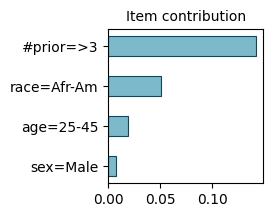

In [12]:
# We can also plot it

fp_diver.plot_shapley_value(pattern = pattern, figsize=(2,2), title="Item contribution")

### Redundancy pruning

We can prune patterns that are redundant, that is, too similar to other patterns.  
This prunes a pattern B if there is a pattern A, subset of B, with a divergence difference below a threshold. 

In [16]:
# We can prune the patterns that are redundant
# We keep only the patterns that are not redundant with a threshold of 0.05

df_pruned = fp_diver.redundancy_pruning(th_redundancy=0.05)
df_pruned.sort_values("fpr_outcome_div", ascending=False).head(5)

,support,itemset,length,support_count,fpr_outcome,fpr_outcome_div,fpr_outcome_t
28,0.293422,(#prior=>3),1,1811.0,0.219269,0.130955,7.503321
44,0.218244,(age=<25),1,1347.0,0.177066,0.088752,5.456070
65,0.177090,(stay=1w-3M),1,1093.0,0.151786,0.063472,3.668118
7,0.514420,(race=Afr-Am),1,3175.0,0.139366,0.051052,5.046409
0,1.000000,(),0,6172.0,0.088314,0.000000,0.000000


### Global Shapley value

We can compute the global shapley value of the pattern divergence across all the patterns 


In [17]:
gsv = fp_diver.global_shapley_value()

For each (frequent) item, we compute its global divergence. 

The Global Shapley value is a generalization of the Shapley value to the entire set of all items. It captures the role of an item in giving rise to divergence jointly with other attributes.

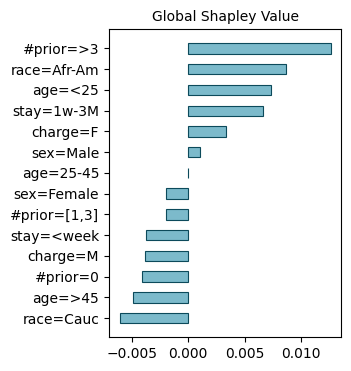

In [18]:
fp_diver.plot_shapley_value(shapley_values=gsv, figsize=(3,4), title='Global Shapley Value')

## Quantitative Outcomes

We can also analyze _quantitative_ outcomes. If $\alpha$ is one such outcome, DivExplorer computes for every subgroup $S$: 

$$
f_\alpha(S) = E[\alpha \mid \alpha \neq NaN]
$$

Again, NaN values are used to disregard some instances (rows) from the statistics. 
The divergence is then defined as before. 

$$
\Delta_\alpha(S) = f_\alpha(S) - f_\alpha(D) , 
$$


In [68]:

df = pd.read_csv("/Users/luca/Downloads/asecpub23csv/pppub23.csv")
df.head()

,PERIDNUM,PH_SEQ,P_SEQ,A_LINENO,PF_SEQ,PHF_SEQ,OED_TYP1,OED_TYP2,OED_TYP3,PERRP,...,I_DISVL1,I_DISVL2,I_SURVL1,I_SURVL2,MIG_CBST,MIG_DSCP,DEP_STAT,FILEDATE,FILESTAT,YYYYMM
0,1577120300625471401101,3,1,1,1,1,0,0,0,40,...,0,0,0,0,0,0,0,72523,5,202303
1,1577120300625471401102,3,2,2,1,1,0,0,0,51,...,0,0,0,0,0,0,0,72523,5,202303
2,4933808620900111501101,4,1,1,1,1,0,0,0,40,...,0,0,0,0,0,0,0,72523,1,202303
3,4933808620900111501102,4,2,2,1,1,0,0,0,42,...,0,0,0,0,0,0,0,72523,1,202303
4,9100075229406531401101,15,1,1,1,1,0,0,0,41,...,0,0,0,0,0,0,0,72523,5,202303


In [81]:
df["PTOTVAL"]

0         12120
1         16800
2          8137
3         42000
4         14713
          ...  
146128        0
146129        0
146130    33113
146131    78092
146132     6865
Name: PTOTVAL, Length: 146133, dtype: int64

In [ ]:
good_attributes = ["A_AGE", "AGE1", "A_HGA", "A_MARITL", "A_SEX", "PEINUSYR", 
                   "PRDTRACE", "A_MJOCC", "PEIO1COW", "A_GRSWK", "PTOTVAL", ]

target = "PTOTVAL"

In [71]:
len(df)

146133

In [ ]:
y_trues = df["class"].values
y_preds = df["predicted"].values

from divexplorer.outcomes import get_false_negative_rate_outcome, get_accuracy_outcome 


df['fnr_outcome'] = get_false_negative_rate_outcome(y_trues, y_preds, negative_value=0, positive_value=1)
df['acc_outcome'] = get_accuracy_outcome(y_trues, y_preds, negative_value=0, positive_value=1)

In [ ]:
df = df.drop(columns=['class', 'predicted'])  

In [ ]:
from divexplorer.divexplorer import DivergenceExplorer

min_sup = 0.1
fp_diver = DivergenceExplorer(
    df)
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, boolean_outcomes = ['fnr_outcome', 'acc_outcome'], show_coincise = True)
FP_fm.sort_values(by="support", ascending=False).head(10)

In [ ]:
from divexplorer.pattern_processor import DivergencePatternProcessor

fp_diver = DivergencePatternProcessor(FP_fm, 'acc_outcome')

pattern = fp_diver.patterns['itemset'].iloc[30]
print(pattern)

fp_diver.plot_shapley_value(pattern = pattern, figsize=(2,2))

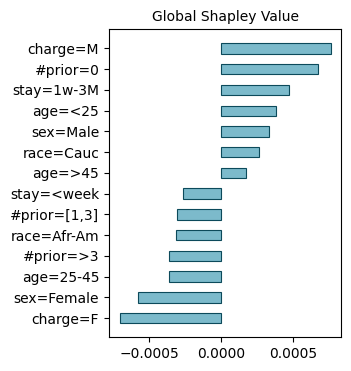

In [63]:
gsv = fp_diver.global_shapley_value()
fp_diver.plot_shapley_value(shapley_values=gsv, figsize=(3,4), title='Global Shapley Value')